In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.989e33
# G = c = 1

def lamba_metric(M, R):
    # Removed factor of 2 since the paper didnt implement it. 
    return -np.log((1-2*G*M/(c**2*R)))

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.998e10)**2)
    pressure = p*((2.998e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value=(0, 0), bounds_error=False)
    return f_e_smooth

In [4]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

def _b(r, M):
    return (2*G*M)/((c**2)*r)

def _dvdr(r, Q, lamda):
    return (2/r) * np.exp(lamda) * Q

def _Q(r, P, M):
    frac = (4 * np.pi * G * (r**2)*P)/(c**4)
    return _b(r, M) + frac

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):    
    # dphidr (From other cowling: arXiv1012.4042)
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

In [5]:
# Working in manual cgs units here. 

# DIMENSIONS UNCHECKED
def _dWdlnr(r, W, U, Q, lamda, l, omega, v, c_ad2):
    term1 = -1*(l+1)*(W-l*np.exp(v+lamda/2)*U)
    frac1 = (np.exp(lamda/2) * (omega*r)**2)/(c_ad2)
    frac2 = (np.exp(lamda/2)*Q*W)/((omega*r)**2)
    print(frac1, frac2, W)
    term2 = frac1 * (U - frac2)
    return term1 - term2

# DIMENSIONS UNCHECKED
def _dUdlnr(r, W, U, v, lamda, l):
    return np.exp(lamda/2 - v) * (W - l*(np.exp(v-lamda/2))*U)

In [6]:
def coupledTOV(r, VEC, init_params):
    P, M, v, W, U = VEC
    EOS, l, omega = init_params
    lamda = lamba_metric(M, r)
    Q = _Q(r, P, M)
    
    e = EOS(P)
    eps = 1e10
    p_eval = np.linspace(P/eps, P*eps, 10)
    e_eval = EOS(p_eval)
    dedp = np.mean(np.gradient(e_eval, p_eval, edge_order=2))
    drhodp = dedp / (c**2)
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dvdr = _dvdr(r, Q, lamda)
    

    c_ad2 = 1/drhodp
    
    # Not sure if taking the log is the correct way to go about it. 
    dWdlnr = _dWdlnr(np.log(r), W, U, Q, lamda, l, omega, v, c_ad2)
    dUdlnr = _dUdlnr(np.log(r), W, U, v, lamda, l)
    
    ret = [dPdr, dMdr, dvdr, dWdlnr, dUdlnr]
    return ret

In [7]:
def tov(ep, init_VEC, r_i, p_min, omega, progress = False, 
        l=2, n_iter_max = 2000):
    
    init_params = [ep, l, omega]

    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
#     r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('VODE')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
            
        if (r.y[0] < p_min):
            break
        
        results.append(integral)
        r_list.append(r.t+dr_init)
        
    if progress:
        pbar.close()
        
    print(r.successful() , (r.y[0] > p_min))
    print(r.y[0], p_min)
    
    
    results = np.array(results, dtype = float)
    p, m, v, w, u = results.T
    r = np.array(r_list)
    return p, m, r, v, w, u

In [8]:
# Load EOS
df = pd.read_csv("eos_data/nl3cr.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p[-10]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3


omega = 1e3*(2*np.pi) #Arbitrary guess
l=2

v0 = 1 # Two step integration optimization: similar to phi previously.

U0 = 1 # Minimize this using f-mode optimizer? 
W0 = l * np.exp(v0)


init_VEC = [p_c, m0, v0, W0, U0]
p_min = min(p) 

# Integrate
p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, 
                             omega,progress = True, 
                             l = l, n_iter_max = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-5-e08f44a2ad83>:7: RuntimeWarning: divide by zero encountered in double_scalars
  frac2 = (np.exp(lamda/2)*Q*W)/((omega*r)**2)
<ipython-input-5-e08f44a2ad83>:9: RuntimeWarning: invalid value encountered in double_scalars
  term2 = frac1 * (U - frac2)
 56%|█████▋    | 1127/2000 [00:00<00:00, 11087.27it/s]

-0.0 inf 5.43656365691809
-2.2549574006440977e-37 nan nan
-2.2549574006440977e-37 nan nan
-9.016824745673894e-37 nan nan
-9.016824745673894e-37 nan nan
-1.8796856056057181e-34 nan nan
-1.8796856056057181e-34 nan nan
-6.947171268810298e-34 nan nan
-6.947171268810298e-34 nan nan
-1.512707150681876e-33 nan nan
-1.512707150681876e-33 nan nan
-2.513406899293325e-32 nan nan
-2.5134068992933256e-32 nan nan
-9.743860731194636e-33 nan nan
-9.743860731194636e-33 nan nan
-2.6070845336512792e-33 nan nan
-2.6070845336512792e-33 nan nan
-3.9844747594208816e-33 nan nan
-3.9844747594208816e-33 nan nan
-5.6376823615649836e-33 nan nan
-7.559732108693588e-33 nan nan
-1.2183509019342209e-32 nan nan
-1.7804103087123827e-32 nan nan
-2.4372843139848894e-32 nan nan
-3.1843872999666275e-32 nan nan
-1.477527562187602e-31 nan nan
-1.477527562187602e-31 nan nan
-3.1841525535569375e-31 nan nan
-3.1841525535569375e-31 nan nan
-5.241635110780629e-31 nan nan
-5.241635110780629e-31 nan nan
-7.5271043447395535e-31 nan 

-1.971601460876375e-26 nan nan
-2.0685811347169568e-26 nan nan
-2.0685845555815663e-26 nan nan
-2.1629265465380957e-26 nan nan
-2.162733470615022e-26 nan nan
-2.1235652065965886e-26 nan nan
-2.123550167463686e-26 nan nan
-2.0798370355655862e-26 nan nan
-2.0798370632816356e-26 nan nan
-2.0912796748035264e-26 nan nan
-2.0912796501856983e-26 nan nan
-2.1029165614386888e-26 nan nan
-2.1029165578240552e-26 nan nan
-2.114752277856978e-26 nan nan
-2.1147522737063745e-26 nan nan
-2.1323035218023106e-26 nan nan
-2.1322900702745425e-26 nan nan
-2.1323035267859208e-26 nan nan
-2.132288572328798e-26 nan nan
-2.118394952843606e-26 nan nan
-2.1183946749493488e-26 nan nan
-2.1218351552512307e-26 nan nan
-2.121834674084071e-26 nan nan
-2.1252967016906074e-26 nan nan
-2.1252967323471006e-26 nan nan
-2.132287597055814e-26 nan nan
-2.1322877841371344e-26 nan nan
-2.1393690321602336e-26 nan nan
-2.1393692853029578e-26 nan nan
-2.146542497665755e-26 nan nan
-2.1465427540425517e-26 nan nan
-2.18859284692692

-7.396667522454216e-26 nan nan
-7.396678058628571e-26 nan nan
-7.423613141350869e-26 nan nan
-7.423616420052405e-26 nan nan
-7.450676004338806e-26 nan nan
-7.450675996953195e-26 nan nan
-7.477854288478938e-26 nan nan
-7.477854293138019e-26 nan nan
-7.532556770201386e-26 nan nan
-7.532556777211336e-26 nan nan
-7.587702920929064e-26 nan nan
-7.587702940597554e-26 nan nan
-7.643271081699e-26 nan nan
-7.643271103559494e-26 nan nan
-7.699238826086871e-26 nan nan
-7.699238848351348e-26 nan nan
-7.755583027888184e-26 nan nan
-7.755583050292206e-26 nan nan
-8.027939056740517e-26 nan nan
-8.028646888332957e-26 nan nan
-7.955223896444906e-26 nan nan
-7.955410498673831e-26 nan nan
-7.795200207195278e-26 nan nan
-7.795200214897643e-26 nan nan
-7.834981562658172e-26 nan nan
-7.834981564274298e-26 nan nan
-7.874918620574178e-26 nan nan
-7.874918624731459e-26 nan nan
-7.915002780255502e-26 nan nan
-7.915002783968532e-26 nan nan
-7.955225294030893e-26 nan nan
-7.955262213539056e-26 nan nan
-7.99584452

-3.3471511716344417e-25 nan nan
-3.36127009072467e-25 nan nan
-3.3612754724570246e-25 nan nan
-3.375619532254231e-25 nan nan
-3.3756195205502e-25 nan nan
-3.4049846719784196e-25 nan nan
-3.4049846077582314e-25 nan nan
-3.435282756041521e-25 nan nan
-3.435282626931543e-25 nan nan
-3.466551782655273e-25 nan nan
-3.4665516497530586e-25 nan nan
-3.498831918625834e-25 nan nan
-3.4988317814709707e-25 nan nan
-3.645221214903215e-25 nan nan
-3.645215126637724e-25 nan nan
-3.8134881134684773e-25 nan nan
-3.813494068303759e-25 nan nan
-4.0009210581080605e-25 nan nan
-4.0006815315718773e-25 nan nan
-3.9139568670528014e-25 nan nan
-3.913948140810349e-25 nan nan
-4.0113215012190587e-25 nan nan
-4.0111717249339007e-25 nan nan
-3.9627074468068054e-25 nan nan
-3.962665535829452e-25 nan nan
-3.923558011031742e-25 nan nan
-3.9235561046250374e-25 nan nan
-3.9332302038915702e-25 nan nan
-3.9332303151821435e-25 nan nan
-3.942971416271844e-25 nan nan
-3.9429715279035736e-25 nan nan
-3.9626570707479574e-25 n

2.766835994789367e-11 nan nan
2.7587282594116698e-11 nan nan
2.7586542163401435e-11 nan nan
2.714162467964895e-11 nan nan
2.7141624830175058e-11 nan nan
2.7250902131760766e-11 nan nan
2.7250882248118213e-11 nan nan
2.7361483009268497e-11 nan nan
2.736148237137921e-11 nan nan
2.7473371076868874e-11 nan nan
2.747339310127669e-11 nan nan
2.7666951617023514e-11 nan nan
2.766696492305944e-11 nan nan
2.7864497411335418e-11 nan nan
2.7864524943390207e-11 nan nan
2.8066176325251284e-11 nan nan
2.8066204465620583e-11 nan nan
2.8670927619308504e-11 nan nan
2.8671026723571566e-11 nan nan
2.9314117892648784e-11 nan nan
2.9313963479559414e-11 nan nan
2.916955710828922e-11 nan nan
2.916947693850784e-11 nan nan
2.9692702920351405e-11 nan nan
2.9692700661645523e-11 nan nan
3.024236556852977e-11 nan nan
3.024235295162007e-11 nan nan
3.08202851746514e-11 nan nan
3.0820271804429725e-11 nan nan
3.206966769047089e-11 nan nan
3.206936247096242e-11 nan nan
3.1777880967530974e-11 nan nan
3.177784597985365e-11

3.9172822632645225e-10 nan nan
3.9172799696219123e-10 nan nan
4.105169326391827e-10 nan nan
4.1051606024762807e-10 nan nan
4.3066450190096406e-10 nan nan
4.3066347129657334e-10 nan nan
4.5232706313785735e-10 nan nan
4.523259494864691e-10 nan nan
4.948193348905935e-10 nan nan
4.948149732605323e-10 nan nan
5.440847857508705e-10 nan nan
5.438523655689911e-10 nan nan
5.438612461642795e-10 nan nan
5.184500603748194e-10 nan nan
5.184258019669011e-10 nan nan
4.994025658277105e-10 nan nan
4.994025753199618e-10 nan nan
5.040635717982176e-10 nan nan
5.040635652411258e-10 nan nan
5.087801009551222e-10 nan nan
5.087800992477621e-10 nan nan
5.135747828615639e-10 nan nan
5.135736262013684e-10 nan nan
5.184438586786362e-10 nan nan
5.18442496845051e-10 nan nan
5.233727243864803e-10 nan nan
5.233753724598823e-10 nan nan
5.283776432181417e-10 nan nan
5.283776388435561e-10 nan nan
5.385863758219211e-10 nan nan
5.38586355967246e-10 nan nan
5.490979264559174e-10 nan nan
5.490978875143468e-10 nan nan
5.5991

7.800265384382614e-09 nan nan
7.800265310637904e-09 nan nan
7.817536214517801e-09 nan nan
7.817536167715703e-09 nan nan
7.830077630107741e-09 nan nan
7.830077581293522e-09 nan nan
7.928909603837852e-09 nan nan
7.928902732425422e-09 nan nan
8.060487702590462e-09 nan nan
8.060488894012262e-09 nan nan
8.151151342506145e-09 nan nan
8.150964151129608e-09 nan nan
8.104613477746532e-09 nan nan
8.10461404894124e-09 nan nan
8.15388018589479e-09 nan nan
8.153755960659765e-09 nan nan
8.123610004377541e-09 nan nan
8.123590219786642e-09 nan nan
8.108350901011124e-09 nan nan
8.108350907604746e-09 nan nan
8.11211854299806e-09 nan nan
8.112118002460038e-09 nan nan
8.115915081930808e-09 nan nan
8.11591431966697e-09 nan nan
8.122678016187914e-09 nan nan
8.122679904598762e-09 nan nan
8.129534309549987e-09 nan nan
8.129536158037986e-09 nan nan
8.136485117753736e-09 nan nan
8.136485115626909e-09 nan nan
8.143528508164023e-09 nan nan
8.143528507104524e-09 nan nan
8.178485218100664e-09 nan nan
8.178484679249

1.124595714835551e-08 nan nan
1.1245957136585942e-08 nan nan
1.1279191866426626e-08 nan nan
1.127919185790723e-08 nan nan
1.134310048581719e-08 nan nan
1.1343039037676472e-08 nan nan
1.1334820365355893e-08 nan nan
1.1334773088456216e-08 nan nan
1.1290839471234545e-08 nan nan
1.1290839495702946e-08 nan nan
1.1302572653169542e-08 nan nan
1.1302572654050712e-08 nan nan
1.1314029498737857e-08 nan nan
1.1314026319946046e-08 nan nan
1.1327515890689038e-08 nan nan
1.1327516019131938e-08 nan nan
1.1341124629860994e-08 nan nan
1.1341124776581177e-08 nan nan
1.13548538864927e-08 nan nan
1.1354854034500035e-08 nan nan
1.1501142660227481e-08 nan nan
1.1501148554355387e-08 nan nan
1.1687723872590538e-08 nan nan
1.1687702930195373e-08 nan nan
1.1940810441734711e-08 nan nan
1.1940799815568662e-08 nan nan
1.213267263142917e-08 nan nan
1.2132665856251706e-08 nan nan
1.2461537198119975e-08 nan nan
1.2461508451675543e-08 nan nan
1.2846323761778428e-08 nan nan
1.2844877386449542e-08 nan nan
1.263253733905

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 58%|█████▊    | 1156/2000 [00:01<00:01, 671.73it/s]  

 nan nan
3.676251474769432e-08 nan nan
3.680794885299256e-08 nan nan
3.680794911877467e-08 nan nan
3.685377364076001e-08 nan nan
3.685376970150838e-08 nan nan
3.696791444795826e-08 nan nan
3.696784981991919e-08 nan nan
3.7095055418322094e-08 nan nan
3.709505941900326e-08 nan nan
3.72241926922686e-08 nan nan
3.7224196756962004e-08 nan nan
3.802271851714335e-08 nan nan
3.8022775229021245e-08 nan nan
3.8595348195918986e-08 nan nan
3.8595282557021743e-08 nan nan
3.9129714562781464e-08 nan nan
3.91296886047197e-08 nan nan
3.970107043266992e-08 nan nan
3.9701045447494676e-08 nan nan
4.091236606932905e-08 nan nan
4.091219769010821e-08 nan nan
4.251950483268486e-08 nan nan
4.251526331209932e-08 nan nan
4.183987954391695e-08 nan nan
4.183977809255143e-08 nan nan
4.251909744310678e-08 nan nan
4.251690582125749e-08 nan nan
4.2154093476913644e-08 nan nan
4.215381237436309e-08 nan nan
4.190929852318112e-08 nan nan
4.1909276118387284e-08 nan nan
4.197927518456614e-08 nan nan
4.19792756990416e-08 nan

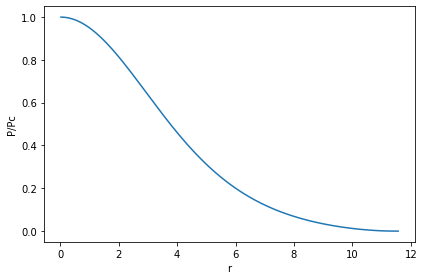

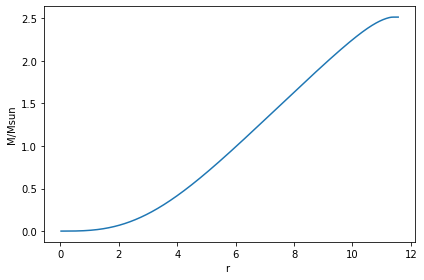

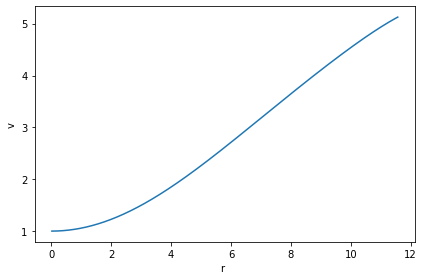

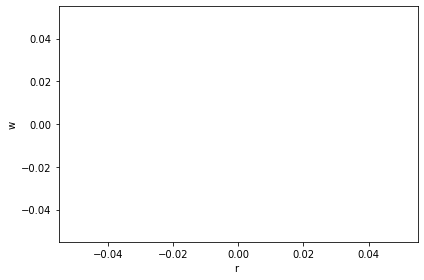

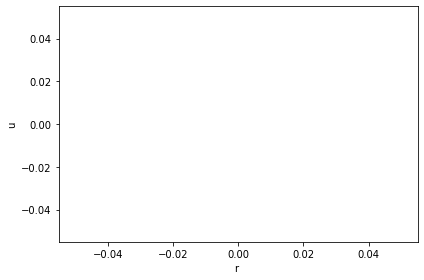

In [9]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, u)
plt.xlabel("r ")
plt.ylabel("u")
plt.show()